In [22]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Use to remove special characters and remove whitespace from player names

# wrs20clean1['Player'] = wrs20clean1['Player'].str.replace('[*,+]','')
# wrs20clean1.Player = wrs20clean1.Player.str.strip()
# wrs19clean1.Player = wrs19clean1.Player.str.replace('[*,+]','')
# wrs19clean1.Player = wrs19clean1.Player.str.strip()
# wrs18clean1.Player = wrs18clean1.Player.str.replace('[*,+]','')
# wrs18clean1.Player = wrs18clean1.Player.str.strip()

# Use to export as Excel workbook for Power BI import

# wrs20clean1.to_excel(r'‪2020clean1.xlsx', index = False)
# wrs19clean1.to_excel(r'2019clean1.xlsx', index = False)
# wrs18clean1.to_excel(r'‪2018clean1.xlsx', index = False)

In [3]:
dataset = pd.read_excel("2020predictions.xlsx")

# Make a copy to add predictions back to dataset - Issues with le.transform_inverse()
datafinal = dataset.copy()

# Can be used to remove other unnecessary columns
datasetclean = dataset.drop(columns=['Rk','Pos','Rec','R/G'])
#datasetclean = dataset.drop(columns=['Rk','Pos','Rec','R/G','Rk_20',
#                                      'Pos_20','Rec_20','R/G_20','Rk_19',
#                                      'Pos_19','Rec_19','R/G_19','Tm',
#                                      'Tm_19','Tm_20'])

# Convert Player and team names to numeric values for model
le = LabelEncoder()
datasetclean['Player'] = le.fit_transform(datasetclean['Player'])
datasetclean['Tm'] = le.fit_transform(datasetclean['Tm'])
### Issues with running le.fit_transform on 'Tm'. Error stating arg needs to be str or number - names are strings, NaNs filled with 0. 
### Decided to simply drop Team from dataset.

# Continue pre-processing data
y = datasetclean['Tgt']
X = datasetclean.copy().drop(columns=['Tgt'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [4]:
### We can verify all categorical values have been converted to numeric. 

#X_train
#y_train
#X

In [5]:
### With certain datasets, converting y_train to int type is required.
### This is as a result of the Label Encoder multiclass type as 'continous'
### https://stackoverflow.com/questions/41925157/logisticregression-unknown-label-type-continuous-using-sklearn-in-python

# int_y = y_train.astype('int64')
# int_y

In [6]:
# Gradient Boosting prediction model

gradRegressor = ensemble.GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    min_samples_leaf=9,
    max_features=0.1,
    loss='huber',
    random_state=0)

# import warnings
# warnings.filterwarnings("ignore")

gradRegressor.fit(X_train, y_train)

grPredict = gradRegressor.predict(X)

datafinal['gbr_prediction'] = grPredict

In [7]:
mse = mean_absolute_error(y_train, gradRegressor.predict(X_train))
print("Training Set Mean Absolute Error: %.4f" % mse)

### Find the error rate on the test set
mse = mean_absolute_error(y_test, gradRegressor.predict(X_test))
print("Test Set Mean Absolute Error: %.4f" % mse)

Training Set Mean Absolute Error: 0.2135
Test Set Mean Absolute Error: 7.2147


In [8]:
# Logistic Regression prediction model

log = LogisticRegression()
log.fit(X_train, y_train)
lrPredict = log.predict(X)
lrProba = log.predict_proba(X)[:,1]

datafinal['lr_prediction'] = lrPredict
datafinal['lr_probability'] = lrProba


In [9]:
lr_mse = mean_absolute_error(y_train, log.predict(X_train))
print("Training mse: %.4f" % lr_mse)

lr_mse = mean_absolute_error(y_test, log.predict(X_test))
print("Training mse: %.4f" % lr_mse)

Training mse: 0.3622
Training mse: 18.9455


In [10]:
datafinal.head(20)

,Unnamed: 0,Rk,Player,Tm,Age,Pos,G,GS,Tgt,Rec,...,TD,1D,Lng,Y/Tgt,R/G,Y/G,Fmb,gbr_prediction,lr_prediction,lr_probability
0,0,1,Stefon Diggs,BUF,27,WR,16,15,166,127,...,8,73,55,9.2,7.9,95.9,0,155.938817,166,1.655139e-143
1,1,3,DeAndre Hopkins,ARI,28,WR,16,16,160,115,...,6,75,60,8.8,7.2,87.9,3,157.174171,160,1.220477e-134
2,2,6,Allen Robinson,CHI,27,WR,16,16,151,102,...,6,68,42,8.3,6.4,78.1,0,150.997454,151,8.864413e-125
3,3,2,Davante Adams,GNB,28,WR,14,14,149,115,...,18,73,56,9.2,8.2,98.1,1,149.003512,149,5.377478e-131
4,4,7,Keenan Allen,LAC,28,WR,14,13,147,100,...,8,61,28,6.7,7.1,70.9,3,114.446270,103,6.631452e-95
5,5,16,Diontae Johnson,PIT,24,WR,15,13,144,88,...,7,45,47,6.4,5.9,61.5,2,123.043581,128,1.110157e-89
6,6,13,Calvin Ridley,ATL,26,WR,15,15,143,90,...,9,65,63,9.6,6.0,91.6,1,142.998443,143,8.355086e-129
7,7,10,Robby Anderson,CAR,27,WR,16,16,136,95,...,3,49,75,8.1,5.9,68.5,1,124.681308,129,2.032166e-90
8,8,17,Tyreek Hill,KAN,26,WR,15,15,135,87,...,15,57,75,9.5,5.8,85.1,1,130.724830,50,1.897804e-106
9,9,18,Terry McLaurin,WAS,25,WR,15,15,134,87,...,4,51,68,8.3,5.8,74.5,1,133.990651,134,4.521086e-104


In [11]:
### Export file to Excel

datafinal.to_excel(r'avgFilled2021predictions.xlsx')

In [12]:
### For plotting purposes, we can remove predicted target values of less than 100.

gt100 = datafinal[datafinal.gbr_prediction > 100]
gt100

,Unnamed: 0,Rk,Player,Tm,Age,Pos,G,GS,Tgt,Rec,...,TD,1D,Lng,Y/Tgt,R/G,Y/G,Fmb,gbr_prediction,lr_prediction,lr_probability
0,0,1,Stefon Diggs,BUF,27,WR,16,15,166,127,...,8,73,55,9.2,7.9,95.9,0,155.938817,166,1.655139e-143
1,1,3,DeAndre Hopkins,ARI,28,WR,16,16,160,115,...,6,75,60,8.8,7.2,87.9,3,157.174171,160,1.220477e-134
2,2,6,Allen Robinson,CHI,27,WR,16,16,151,102,...,6,68,42,8.3,6.4,78.1,0,150.997454,151,8.864413e-125
3,3,2,Davante Adams,GNB,28,WR,14,14,149,115,...,18,73,56,9.2,8.2,98.1,1,149.003512,149,5.377478e-131
4,4,7,Keenan Allen,LAC,28,WR,14,13,147,100,...,8,61,28,6.7,7.1,70.9,3,114.446270,103,6.631452e-95
5,5,16,Diontae Johnson,PIT,24,WR,15,13,144,88,...,7,45,47,6.4,5.9,61.5,2,123.043581,128,1.110157e-89
6,6,13,Calvin Ridley,ATL,26,WR,15,15,143,90,...,9,65,63,9.6,6.0,91.6,1,142.998443,143,8.355086e-129
7,7,10,Robby Anderson,CAR,27,WR,16,16,136,95,...,3,49,75,8.1,5.9,68.5,1,124.681308,129,2.032166e-90
8,8,17,Tyreek Hill,KAN,26,WR,15,15,135,87,...,15,57,75,9.5,5.8,85.1,1,130.724830,50,1.897804e-106
9,9,18,Terry McLaurin,WAS,25,WR,15,15,134,87,...,4,51,68,8.3,5.8,74.5,1,133.990651,134,4.521086e-104


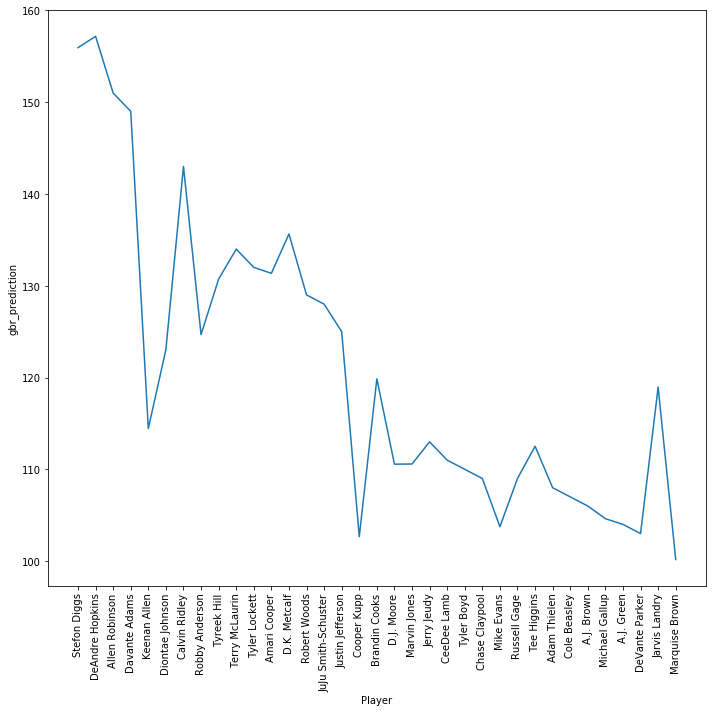

In [13]:
### Adjust figure size if desired

plt.figure(figsize=(10,10))

visual = sns.lineplot(data=gt100, x="Player", y="gbr_prediction")
visual.set_xticklabels(gt100['Player'], rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [14]:
avgFilled = pd.read_excel(r'avgFilled2021predictions.xlsx')

In [15]:
avg100 = avgFilled[avgFilled.gbr_prediction > 100]
avg100

,Unnamed: 0,Unnamed: 0.1,Rk,Player,Tm,Age,Pos,G,GS,Tgt,...,TD,1D,Lng,Y/Tgt,R/G,Y/G,Fmb,gbr_prediction,lr_prediction,lr_probability
0,0,0,1,Stefon Diggs,BUF,27,WR,16,15,166,...,8,73,55,9.2,7.9,95.9,0,155.938817,166,1.655139e-143
1,1,1,3,DeAndre Hopkins,ARI,28,WR,16,16,160,...,6,75,60,8.8,7.2,87.9,3,157.174171,160,1.220477e-134
2,2,2,6,Allen Robinson,CHI,27,WR,16,16,151,...,6,68,42,8.3,6.4,78.1,0,150.997454,151,8.864413e-125
3,3,3,2,Davante Adams,GNB,28,WR,14,14,149,...,18,73,56,9.2,8.2,98.1,1,149.003512,149,5.377478e-131
4,4,4,7,Keenan Allen,LAC,28,WR,14,13,147,...,8,61,28,6.7,7.1,70.9,3,114.446270,103,6.631452e-95
5,5,5,16,Diontae Johnson,PIT,24,WR,15,13,144,...,7,45,47,6.4,5.9,61.5,2,123.043581,128,1.110157e-89
6,6,6,13,Calvin Ridley,ATL,26,WR,15,15,143,...,9,65,63,9.6,6.0,91.6,1,142.998443,143,8.355086e-129
7,7,7,10,Robby Anderson,CAR,27,WR,16,16,136,...,3,49,75,8.1,5.9,68.5,1,124.681308,129,2.032166e-90
8,8,8,17,Tyreek Hill,KAN,26,WR,15,15,135,...,15,57,75,9.5,5.8,85.1,1,130.724830,50,1.897804e-106
9,9,9,18,Terry McLaurin,WAS,25,WR,15,15,134,...,4,51,68,8.3,5.8,74.5,1,133.990651,134,4.521086e-104


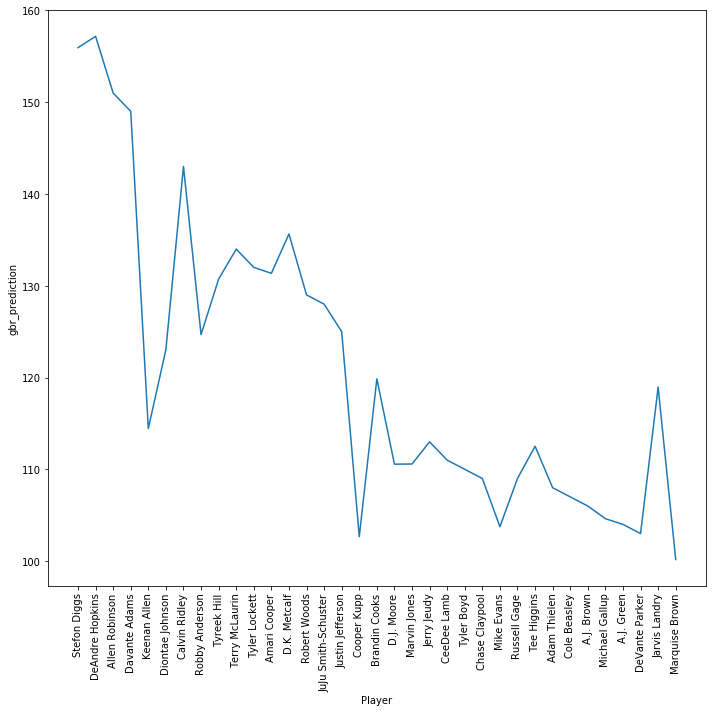

In [16]:
plt.figure(figsize=(10,10))

visual = sns.lineplot(data=avg100, x="Player", y="gbr_prediction")
visual.set_xticklabels(avg100['Player'], rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [18]:
addExtra = pd.read_excel('2020predictions.xlsx')
addExtra.head(15)

,Unnamed: 0,Rk,Player,Tm,Age,Pos,G,GS,Tgt,Rec,...,TD,1D,Lng,Y/Tgt,R/G,Y/G,Fmb,gbr_prediction,lr_prediction,lr_probability
0,0,1,Stefon Diggs,BUF,27,WR,16,15,166,127,...,8,73,55,9.2,7.9,95.9,0,154.664976,166,1.686517e-145
1,1,3,DeAndre Hopkins,ARI,28,WR,16,16,160,115,...,6,75,60,8.8,7.2,87.9,3,160.000590,160,7.584306e-134
2,2,6,Allen Robinson,CHI,27,WR,16,16,151,102,...,6,68,42,8.3,6.4,78.1,0,148.189306,151,9.013635e-124
3,3,2,Davante Adams,GNB,28,WR,14,14,149,115,...,18,73,56,9.2,8.2,98.1,1,149.001045,149,1.073146e-133
4,4,7,Keenan Allen,LAC,28,WR,14,13,147,100,...,8,61,28,6.7,7.1,70.9,3,104.996185,103,6.741650e-100
5,5,16,Diontae Johnson,PIT,24,WR,15,13,144,88,...,7,45,47,6.4,5.9,61.5,2,107.680483,129,1.517997e-86
6,6,13,Calvin Ridley,ATL,26,WR,15,15,143,90,...,9,65,63,9.6,6.0,91.6,1,143.004495,143,3.871340e-132
7,7,10,Robby Anderson,CAR,27,WR,16,16,136,95,...,3,49,75,8.1,5.9,68.5,1,135.959329,61,2.681078e-96
8,8,17,Tyreek Hill,KAN,26,WR,15,15,135,87,...,15,57,75,9.5,5.8,85.1,1,129.330531,82,7.002097e-116
9,9,18,Terry McLaurin,WAS,25,WR,15,15,134,87,...,4,51,68,8.3,5.8,74.5,1,133.587909,134,1.899441e-101


In [19]:
beforeAdd = addExtra.gbr_prediction

0      154.664976
1      160.000590
2      148.189306
3      149.001045
4      104.996185
          ...    
177      4.510055
178      4.005463
179     13.218970
180      4.000906
181      4.288523
Name: gbr_prediction, Length: 182, dtype: float64

In [23]:
def extraGame(x):
    game17 = np.divide(x,16)
    return  x + game17

In [24]:
afterAdd = extraGame(beforeAdd)

In [25]:
afterAdd

0      164.331536
1      170.000627
2      157.451138
3      158.313610
4      111.558447
          ...    
177      4.791933
178      4.255805
179     14.045155
180      4.250963
181      4.556556
Name: gbr_prediction, Length: 182, dtype: float64

In [38]:
addExtra.gbr_prediction = afterAdd

In [39]:
addExtra

,Unnamed: 0,Rk,Player,Tm,Age,Pos,G,GS,Tgt,Rec,...,TD,1D,Lng,Y/Tgt,R/G,Y/G,Fmb,gbr_prediction,lr_prediction,lr_probability
0,0,1,Stefon Diggs,BUF,27,WR,16,15,166,127,...,8,73,55,9.2,7.9,95.9,0,164.331536,166,1.686517e-145
1,1,3,DeAndre Hopkins,ARI,28,WR,16,16,160,115,...,6,75,60,8.8,7.2,87.9,3,170.000627,160,7.584306e-134
2,2,6,Allen Robinson,CHI,27,WR,16,16,151,102,...,6,68,42,8.3,6.4,78.1,0,157.451138,151,9.013635e-124
3,3,2,Davante Adams,GNB,28,WR,14,14,149,115,...,18,73,56,9.2,8.2,98.1,1,158.313610,149,1.073146e-133
4,4,7,Keenan Allen,LAC,28,WR,14,13,147,100,...,8,61,28,6.7,7.1,70.9,3,111.558447,103,6.741650e-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,177,399,Lil'Jordan Humphrey,NOR,22,WR,3,1,5,3,...,1,3,17,9.2,1.0,15.3,0,4.791933,8,3.726160e-07
178,178,419,Antonio Callaway,MIA,23,WR,5,1,4,2,...,0,1,13,5.0,0.4,4.0,0,4.255805,4,5.798766e-04
179,179,411,Brandon Zylstra,CAR,27,WR,16,2,4,3,...,0,3,28,8.8,0.2,2.2,0,14.045155,6,9.561796e-02
180,180,385,Riley Ridley,CHI,24,WR,5,1,4,4,...,0,3,18,9.8,0.8,7.8,0,4.250963,4,6.879953e-02


In [40]:
addExtra.to_excel(r'17gamePredictions.xlsx')